In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

pd.set_option('display.max_columns',500)

data = pd.read_csv("AmesHousing.tsv",sep='\t')

print(data.shape)
print(len(str(data.shape))*'-')
print(data.dtypes.value_counts())
#data.head()
#data.info()


(2930, 82)
----------
object     43
int64      28
float64    11
dtype: int64


In [197]:
def transform_features(df, percent_missing=0.05):
    
    #Suppression de valeurs manquantes supprimées en fonction du %, ici 5% car 2930 lignes
    num_missing = df.isnull().sum()
    #print(num_missing)
    drop_missing_cols = num_missing[(num_missing > len(df)*percent_missing)].sort_values()
    df_clean = df.drop(drop_missing_cols.index, axis=1)
    
    #colonnes textes : suppression les colonnes avec au moins une valeur manquante
    text_mv_counts = df_clean.select_dtypes(include="object").isnull().sum().sort_values(ascending=False)   
    #Filtre sur les colonnes contenant au moins une valeur manquante
    df_clean = df_clean.drop(text_mv_counts[text_mv_counts > 0].index, axis=1)
    print(df_clean.shape[1])
    
    #Colonnes numériques : on remplace la valeur manquante par la valeur la plus fréquente de la colonne
    num_missing = df_clean.select_dtypes(include=["float","integer"]).isnull().sum()
    fix_num_missing_cols = num_missing[(num_missing < len(df_clean)*percent_missing) & (num_missing > 0)].sort_values()
    replace_val_dict = df_clean[fix_num_missing_cols.index].mode().to_dict(orient='records')[0]
    df_clean = df_clean.fillna(replace_val_dict)
    df_clean.isnull().sum().value_counts()
    print(df_clean.shape[1])
    #print(len(df))
    
    #Nouvelles caractéristiques à partir de celles existantes
    years_sold = df_clean["Yr Sold"] - df_clean["Year Built"]
    years_sold[years_sold < 0]
    years_since_remod = df_clean["Yr Sold"] - df_clean["Year Remod/Add"]
    years_since_remod[years_since_remod < 0]
    #Creation de 2 nouvelles colonnes
    df_clean["Years before Sole"] = years_sold
    df_clean["Years since Remod"] = years_since_remod
    #Suppression des valeurs négatives
    df_clean = df_clean.drop([1702, 2180, 2181], axis=0)
    #Suppression des colonnes d'origine
    df_clean.drop(["Year Built","Year Remod/Add"], axis=1)
    
    #Supprimer les colonnes qui ne sont pas utiles pour le ML
    df_clean.drop(["PID","Order"], axis=1)
    #Supprimer les colonnes des fuites de données
    df_clean.drop(["Mo Sold","Sale Condition","Sale Type","Yr Sold"], axis=1)
    
    df_clean.head()
    
    return df_clean
    

In [198]:
def select_features(df, coeff_corr=0.4):
    
    #selection des caractéristiques numériques et on étudie leur correlation avec SalePrice
    df = df.select_dtypes(include=["int","float"])
    abs_corr_coeffs = df.corr()["SalePrice"].abs().sort_values()
    abs_corr_coeffs[abs_corr_coeffs > coeff_corr]
    #Suppression des colonnes avec coeff de corrélation inférieur de 0.4 avec SalePrice
    transform_df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_corr].index, axis=1)
    transform_df.shape[1]
    
    #Colonnes qui sont catégoriques
    nominal_features = ["PID","MS SubClass","MS Zoning","Street","Alley"]
    transform_cat_cols = []
    for col in nominal_features:
        if col in transform_df.columns:
            transform_cat_cols.append(col)
    
    
    #print(transform_cat_cols)
    transform_df = df[["Gr Liv Area","SalePrice"]]
    
    return transform_df
    

In [199]:
def train_and_test(data, k=0):
    
    numeric_train = data.select_dtypes(include=["integer","float"])
    numeric_test  = data.select_dtypes(include=["integer","float"])
    
    lr = linear_model.LinearRegression()
    
    if k == 0:
    
        train = data.iloc[0:1460] 
        test  = data.iloc[1460:]
    
        features = numeric_train.columns.drop("SalePrice")
    
        #Entrainement
        lr.fit(train[features],train["SalePrice"])
    
        #Prediction
        test_predictions  = lr.predict(test[features])
        test_mse = mean_squared_error(test_predictions, test["SalePrice"])
    
        test_rmse = np.sqrt(test_mse)
    
        return test_rmse

    if k == 1:
    
        shuffled_data = data.sample(frac=1,)
        train = data.iloc[0:1460] 
        test  = data.iloc[1460:]
    
        features = numeric_train.columns.drop("SalePrice")
    
        #Entrainement sur les données d'entrainement
        lr.fit(train[features],train["SalePrice"])
    
        #Prediction sur les données de test
        test_predictions_one  = lr.predict(test[features])
    
        test_mse_one = mean_squared_error(test_predictions_one, test["SalePrice"])
        test_rmse_one = np.sqrt(test_mse_one)
    
    
        #Entrainement sur les données de test
        lr.fit(test[features],test["SalePrice"])
    
        #Prediction sur les données d'entraienement
        train_predictions_two  = lr.predict(train[features])
    
        train_mse_two = mean_squared_error(train_predictions_two, train["SalePrice"])
        train_rmse_two = np.sqrt(train_mse_two)    
    
        avg_rmse = np.mean([test_rmse_one, train_rmse_two])
    
        return avg_rmse

    else:
        
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values=[]
        features = numeric_train.columns.drop("SalePrice")
        
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test  = data.iloc[test_index]
            
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            
            mse = mean_squared_error(predictions, test["SalePrice"])
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)

        #print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        
        return avg_rmse
    

64
64


Text(0, 0.5, 'RMSE')

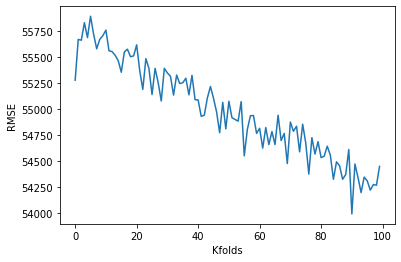

In [200]:
transform_df = transform_features(data, 0.05)
filtered_df = select_features(transform_df, 0.4)

results=[]
for i in range(100):
    result = train_and_test(filtered_df,k=i)
    results.append(result)
    
x = [i for i in range(100)]
y = results
plt.plot(x,y)
plt.xlabel("Kfolds")
plt.ylabel("RMSE")
